<a href="https://colab.research.google.com/github/Hardik0175/Graph_Mining/blob/main/Hardik_Sharma_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get install libcairo2-dev libjpeg-dev libgif-dev
!pip install pycairo
!pip install python-igraph
!pip install plfit
!pip install networkx

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libjpeg-dev is already the newest version (8c-2ubuntu8).
libjpeg-dev set to manually installed.
The following additional packages will be installed:
  libcairo-script-interpreter2 libpixman-1-dev libxcb-shm0-dev
Suggested packages:
  libcairo2-doc
The following NEW packages will be installed:
  libcairo-script-interpreter2 libcairo2-dev libgif-dev libpixman-1-dev
  libxcb-shm0-dev
0 upgraded, 5 newly installed, 0 to remove and 11 not upgraded.
Need to get 951 kB of archives.
After this operation, 4,084 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libcairo-script-interpreter2 amd64 1.15.10-2ubuntu0.1 [53.5 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libpixman-1-dev amd64 0.34.0-2 [244 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libxcb-shm0-dev amd64 1.13-2~ubuntu18.04 [6,684 B]
Get:4 http:/

In [2]:
datadir='/content/gdrive/My Drive/Datasets/'
## for loading dataset from google drive

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import igraph as ig
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

from collections import Counter

In [4]:
## define the colors and node sizes here
cls_edges = 'gainsboro'
cls = ['silver','dimgray','black']
sz = [6,9,12]

In [5]:
## read edges and build weighted directed graph
D = pd.read_csv(datadir+'Airports/connections.csv')
g = ig.Graph.TupleList([tuple(x) for x in D.values], directed=True, edge_attrs=['weight'])
df = D.head()

In [6]:
## read vertex attributes and add to graph
A = pd.read_csv(datadir+'Airports/airports_loc.csv')
lookup = {k:v for v,k in enumerate(A['airport'])}
l = [lookup[x] for x in g.vs()['name']]
g.vs()['layout'] = [(A['lon'][i],A['lat'][i]) for i in l]
g.vs()['state'] = [A['state'][i] for i in l]
g.vs()['city'] = [A['city'][i] for i in l]
## add a few more attributes for visualization
g.vs()['size'] = sz[1]
g.vs()['color'] = cls[1]
g.es()['color'] = cls_edges
g.es()['arrow_size'] = 0.33
df = A.head()
print(g.vcount(),'nodes and',g.ecount(),'directed edges')

464 nodes and 12000 directed edges


# Problem 1
Top 5 ranked airport in NY state

In [7]:
## Build smaller subgraph for California (you can try other states)
hva = [v for v in g.vs() if v['state'] == 'NY']
G = g.subgraph(hva)

## drop isolated vertices (i.e. without in-state connections)
G = G.subgraph([v for v in G.vs() if v.degree()>0])

## remove loops
G = G.simplify(multiple=False)
print(G.vcount(),'nodes and',G.ecount(),'directed edges')


13 nodes and 50 directed edges


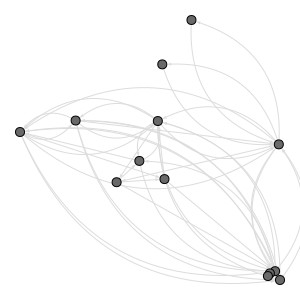

In [8]:
## plot using lat/lon as layout
ly = ig.Layout(G.vs['layout'])
ly.mirror(1)
ig.plot(G, bbox=(0,0,300,300), layout=ly)

In [9]:
## compute normalized weights 
mw = np.max(G.es['weight'])
G.es()['normalized_weight'] = [w/mw for w in G.es()['weight']]

In [10]:
## directed degree centrality
def degree_centrality(g, weights=None):
    n = g.vcount()
    if g.is_directed():
        dc = [sum(x)/(2*(n-1)) for x in zip(G.strength(mode='in',weights=weights),\
              G.strength(mode='out',weights=weights))]
    else:
        dc = [x/(n-1) for x in G.strength(weights=weights)]
    return dc

In [11]:
## compute several centrality measures
C = pd.DataFrame({'airport':G.vs()['name'],\
                  'degree':degree_centrality(G,weights='normalized_weight'),\
                  'pagerank':G.pagerank(weights='weight'),'authority':G.authority_score(weights='weight'),\
                  'hub':G.hub_score(weights='weight'),'between':G.betweenness(),\
                  'closeness':G.closeness()})
## normalize betweenness
n = G.vcount()
C['between'] = [2*x/((n-1)*(n-2)) for x in C['between']]
## sort w.r.t. degree centrality
Cs = C.sort_values(by='degree', ascending=False)
df = Cs.head()
df

,airport,degree,pagerank,authority,hub,between,closeness
0,JFK,0.173125,0.342720,1.000000,0.373760,0.647727,0.705882
2,BUF,0.101629,0.195702,0.261299,1.000000,0.167929,0.705882
4,ROC,0.054908,0.109433,0.141841,0.546989,0.000000,0.631579
5,SYR,0.044959,0.097118,0.113975,0.459400,0.243687,0.750000
1,LGA,0.040011,0.108312,0.213367,0.078989,0.286616,0.750000


# Problem 2

All the centrality measure increase with increase in degree

In [12]:
## fast Chung-Lu: generate m edges w.r.t. distribution d
def fastCL(d, m):
    n = len(d)
    s = np.sum(d)
    p = [i/s for i in d]
    target = m
    tples = []
    while len(tples) < target:
        s = target - len(tples)
        e0 = np.random.choice(n, size=s, replace=True, p=p)
        e1 = np.random.choice(n, size=s, replace=True, p=p)
        tples.extend([(min(e0[i],e1[i]),max(e0[i],e1[i])) for i in range(len(e0)) if e0[i]!=e1[i]]) ## ignore loops
        tples = list(set(tples)) ## drop collisions
    return tples


In [13]:
## power law graph
gamma = 2.5
n = 10000
delta = 1
Delta = np.sqrt(n)
W = []
for i in np.arange(1,n+1):
    W.append(delta * (n/(i-1+n/(Delta/delta)**(gamma-1)))**(1/(gamma-1)))

deg = [int(np.round(w)) for w in W]
m = int(np.mean(deg)*n/2)
tpl = fastCL(deg,m)
g1 = ig.Graph.TupleList(tpl,directed=False)

In [14]:
## directed degree centrality
def degree_centrality(g, weights=None):
    n = g.vcount()
    if g.is_directed():
        dc = [sum(x)/(2*(n-1)) for x in zip(G.strength(mode='in',weights=weights),\
              G.strength(mode='out',weights=weights))]
    else:
        dc = [x/(n-1) for x in g.strength(weights=weights)]
    return dc

In [15]:
## compute several centrality measures
C = pd.DataFrame({'id':g1.vs()['name'],\
                  'degree centrality':degree_centrality(g1),\
                  'pagerank':g1.pagerank(),'authority':g1.authority_score(),\
                  'hub':g1.hub_score(),'between':g1.betweenness(directed=False),\
                  'closeness':g1.closeness(),'degree':g1.degree()})
## normalize betweenness
n = g1.vcount()
C['between'] = [2*x/((n-1)*(n-2)) for x in C['between']]
## sort w.r.t. degree centrality
Cs = C.sort_values(by='degree',ascending=False)
df = Cs.head()
df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: closeness centrality is not well-defined for disconnected graphs at ../../../source/igraph/src/centrality.c:2874
  


,id,degree centrality,pagerank,authority,hub,between,closeness,degree
103,0,0.013498,0.003041,1.000000,1.000000,0.078536,0.002887,107
173,1,0.012363,0.002916,0.789246,0.789246,0.053485,0.002886,98
32,2,0.011984,0.002763,0.849806,0.849806,0.061393,0.002887,95
113,3,0.011606,0.002728,0.644813,0.644813,0.056185,0.002886,92
286,5,0.011101,0.002507,0.956843,0.956843,0.067923,0.002888,88


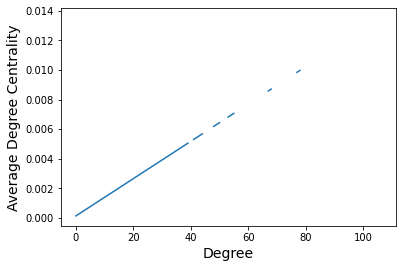

In [16]:
arr = [0]*df.degree.max()
arr2 = [0]*df.degree.max()
for i in range(df.degree.max()):
  arr[i] = float(C.query("degree == "+str(i+1))['degree centrality'].mean())
  arr2[i] = i+1
  
degree_centrality = np.array(arr)
np.nan_to_num(degree_centrality);

plt.plot(degree_centrality)
plt.xlabel('Degree',fontsize=14)
plt.ylabel('Average Degree Centrality',fontsize=14);



Degree Centrality is linear with the degree

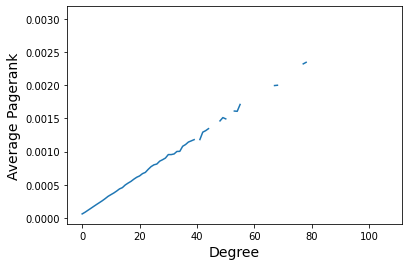

In [17]:
arr = [0]*df.degree.max()
for i in range(df.degree.max()):
  arr[i] = float(C.query("degree == "+str(i+1))['pagerank'].mean())

pagerank_c = np.array(arr)
np.nan_to_num(pagerank_c);

plt.plot(pagerank_c)
plt.xlabel('Degree',fontsize=14)
plt.ylabel('Average Pagerank',fontsize=14);

Average Pagerank also increases with increase in degree 

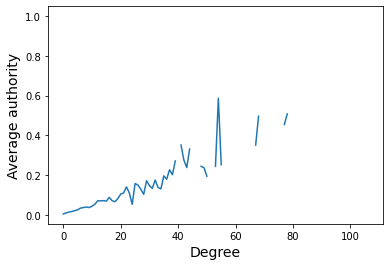

In [18]:
arr = [0]*df.degree.max()
for i in range(df.degree.max()):
  arr[i] = float(C.query("degree == "+str(i+1))['authority'].mean())

authority_c = np.array(arr)
np.nan_to_num(authority_c);

plt.plot(authority_c)
plt.xlabel('Degree',fontsize=14)
plt.ylabel('Average authority',fontsize=14);

Average Authority also increases with increase in degree

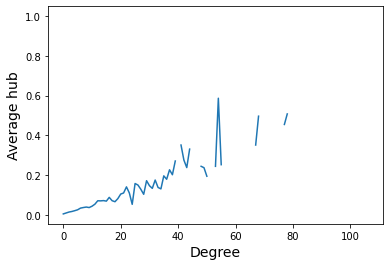

In [19]:
arr = [0]*df.degree.max()
for i in range(df.degree.max()):
  arr[i] = float(C.query("degree == "+str(i+1))['hub'].mean())

hub_c = np.array(arr)
np.nan_to_num(hub_c);

plt.plot(hub_c)
plt.xlabel('Degree',fontsize=14)
plt.ylabel('Average hub',fontsize=14);

Average hub also increases with increase in degree

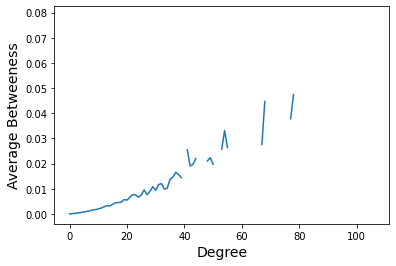

In [20]:
arr = [0]*df.degree.max()
for i in range(df.degree.max()):
  arr[i] = float(C.query("degree == "+str(i+1))['between'].mean())

between_c = np.array(arr)
np.nan_to_num(between_c);

plt.plot(between_c)
plt.xlabel('Degree',fontsize=14)
plt.ylabel('Average Betweeness',fontsize=14);

Average Betweeness also increases with increase in degree


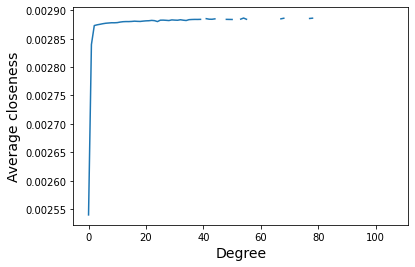

In [21]:
arr = [0]*df.degree.max()
for i in range(df.degree.max()):
  arr[i] = float(C.query("degree == "+str(i+1))['closeness'].mean())

between_c = np.array(arr)
np.nan_to_num(between_c);

plt.plot(between_c)
plt.xlabel('Degree',fontsize=14)
plt.ylabel('Average closeness',fontsize=14);

Average Closeness also increases from small degrees

# Problem 3

*   Desgree Centrality (Nodes with large score to be deleted: 2 & Low: 178)  
*   Pagerank (Nodes with large score need to be deleted: 2 & Low: 35)
*   Authority (Nodes with large score need to be deleted: 2 & Low: 6)
*   Hub (Nodes with large score need to be deleted: 2 & Low: 461)
*   Betweeness (Nodes with large score need to be deleted: 4 & Low: 461)
*   Closeness (Nodes with large score need to be deleted: 1 & 461)



In [22]:
g_new = g.copy()
cl = g_new.components(mode = 'WEAK').membership

for i in range(len(cl)):
  if cl[i] == 1:
    g_new.delete_vertices(i)

g_new = g_new.subgraph([v for v in g_new.vs() if v.degree()>0])

g_new.is_connected(mode='WEAK')
c = g_new.vcount()

In [23]:
## compute normalized weights 
mw = np.max(g_new.es['weight'])
g_new.es()['normalized_weight'] = [w/mw for w in g_new.es()['weight']]

In [24]:
## directed degree centrality
def degree_centrality(g, weights=None):
    n = g.vcount()
    if g.is_directed():
        dc = [sum(x)/(2*(n-1)) for x in zip(g.strength(mode='in',weights=weights),\
              g.strength(mode='out',weights=weights))]
    else:
        dc = [x/(n-1) for x in g.strength(weights=weights)]
    return dc

In [25]:
## compute several centrality measures
C = pd.DataFrame({'airport':g_new.vs()['name'],\
                  'degree centraliy':degree_centrality(g_new,weights='normalized_weight'),\
                  'pagerank':g_new.pagerank(weights='weight'),'authority':g_new.authority_score(weights='weight'),\
                  'hub':g_new.hub_score(weights='weight'),'between':g_new.betweenness(),\
                  'closeness':g_new.closeness()})
## normalize betweenness
n = g_new.vcount()
C['between'] = [2*x/((n-1)*(n-2)) for x in C['between']]
## sort w.r.t. degree centrality
Cs = C.sort_values(by='degree centraliy', ascending=False,ignore_index=False)
Cs.head()

,airport,degree centraliy,pagerank,authority,hub,between,closeness
3,ATL,0.053513,0.051337,1.000000,1.000000,0.088927,0.593548
9,ORD,0.039813,0.037664,0.837524,0.837720,0.056191,0.598958
11,DFW,0.034460,0.035132,0.714629,0.718580,0.064718,0.579345
1,LAX,0.029772,0.026637,0.765373,0.768892,0.051827,0.559611
10,LAS,0.027570,0.026369,0.654271,0.659883,0.092798,0.579345


In [26]:
## compute several centrality measures
C = pd.DataFrame({'airport':g_new.vs()['name'],\
                  'degree centraliy':degree_centrality(g_new,weights='normalized_weight'),\
                  'pagerank':g_new.pagerank(weights='weight'),'authority':g_new.authority_score(weights='weight'),\
                  'hub':g_new.hub_score(weights='weight'),'between':g_new.betweenness(),\
                  'closeness':g_new.closeness()})
## normalize betweenness
n = g_new.vcount()
C['between'] = [2*x/((n-1)*(n-2)) for x in C['between']]
## sort w.r.t. degree centrality
Cs = C.sort_values(by='degree centraliy', ascending=False,ignore_index=True)
Cs.head()

,airport,degree centraliy,pagerank,authority,hub,between,closeness
0,ATL,0.053513,0.051337,1.000000,1.000000,0.088927,0.593548
1,ORD,0.039813,0.037664,0.837524,0.837720,0.056191,0.598958
2,DFW,0.034460,0.035132,0.714629,0.718580,0.064718,0.579345
3,LAX,0.029772,0.026637,0.765373,0.768892,0.051827,0.559611
4,LAS,0.027570,0.026369,0.654271,0.659883,0.092798,0.579345


In [27]:
g_new.is_connected(mode='WEAK')
g_centr = g_new.copy()
cond = True
i = 0
while cond:
  g_centr.delete_vertices(Cs.airport[i])
  i+=1
  if not g_centr.is_connected(mode='WEAK') or g_centr.vcount==0 or i==c:
    cond = False
print(i)

2


In [28]:
Cs = C.sort_values(by='degree centraliy', ascending=True,ignore_index=True)
Cs.head()
g_centr = g_new.copy()

cond = True
i = 0
while cond:
  g_centr.delete_vertices(Cs.airport[i])
  i+=1
  if not g_centr.is_connected(mode='WEAK') or g_centr.vcount==0 or i==c:
    cond = False
print(i)

178


In [29]:
Cs = C.sort_values(by='pagerank', ascending=False,ignore_index=True)
Cs.head()
g_centr = g_new.copy()

cond = True
i = 0
while cond:
  g_centr.delete_vertices(Cs.airport[i])
  i+=1
  if not g_centr.is_connected(mode='WEAK') or g_centr.vcount==0 or i==c:
    cond = False
print(i)

2


In [30]:
Cs = C.sort_values(by='pagerank', ascending=True,ignore_index=True)
Cs.head()
g_centr = g_new.copy()

cond = True
i = 0
while cond:
  g_centr.delete_vertices(Cs.airport[i])
  i+=1
  if not g_centr.is_connected(mode='WEAK') or g_centr.vcount==0 or i==c:
    cond = False
print(i)

35


In [31]:
Cs = C.sort_values(by='authority', ascending=False,ignore_index=True)
Cs.head()
g_centr = g_new.copy()

cond = True
i = 0
while cond:
  g_centr.delete_vertices(Cs.airport[i])
  i+=1
  if not g_centr.is_connected(mode='WEAK') or g_centr.vcount==0 or i==c:
    cond = False
print(i)

2


In [32]:
Cs = C.sort_values(by='authority', ascending=True,ignore_index=True)
Cs.head()
g_centr = g_new.copy()

cond = True
i = 0
while cond:
  g_centr.delete_vertices(Cs.airport[i])
  i+=1
  if not g_centr.is_connected(mode='WEAK') or g_centr.vcount==0 or i==c:
    cond = False
print(i)

6


In [33]:
Cs = C.sort_values(by='hub', ascending=False,ignore_index=True)
Cs.head()
g_centr = g_new.copy()

cond = True
i = 0
while cond:
  g_centr.delete_vertices(Cs.airport[i])
  i+=1
  if not g_centr.is_connected(mode='WEAK') or g_centr.vcount==0 or i==c:
    cond = False
print(i)

2


In [34]:
Cs = C.sort_values(by='hub', ascending=True,ignore_index=True)
Cs.head()
g_centr = g_new.copy()

cond = True
i = 0
while cond:
  g_centr.delete_vertices(Cs.airport[i])
  i+=1
  if not g_centr.is_connected(mode='WEAK') or g_centr.vcount==0 or i==c:
    cond = False
print(i)

461


In [35]:
Cs = C.sort_values(by='between', ascending=False,ignore_index=True)
Cs.head()
g_centr = g_new.copy()

cond = True
i = 0
while cond:
  g_centr.delete_vertices(Cs.airport[i])
  i+=1
  if not g_centr.is_connected(mode='WEAK') or g_centr.vcount==0 or i==c:
    cond = False
print(i)

4


In [36]:
Cs = C.sort_values(by='between', ascending=True,ignore_index=True)
Cs.head()
g_centr = g_new.copy()

cond = True
i = 0
while cond:
  g_centr.delete_vertices(Cs.airport[i])
  i+=1
  if not g_centr.is_connected(mode='WEAK') or g_centr.vcount==0 or i==c:
    cond = False
print(i)

461


In [37]:
Cs = C.sort_values(by='closeness', ascending=False,ignore_index=True)
Cs.head()
g_centr = g_new.copy()

cond = True
i = 0
while cond:
  g_centr.delete_vertices(Cs.airport[i])
  i+=1
  if not g_centr.is_connected(mode='WEAK') or g_centr.vcount==0 or i==c:
    cond = False
print(i)

1


In [38]:
Cs = C.sort_values(by='closeness', ascending=True,ignore_index=True)
Cs.head()
g_centr = g_new.copy()

cond = True
i = 0
while cond:
  g_centr.delete_vertices(Cs.airport[i])
  i+=1
  if not g_centr.is_connected(mode='WEAK') or g_centr.vcount==0 or i==c:
    cond = False
print(i)

461


# Problem 4

In [39]:
## directed degree centrality
def degree_centrality(g, weights=None):
    n = g.vcount()
    if g.is_directed():
        dc = [sum(x)/(2*(n-1)) for x in zip(g.strength(mode='in',weights=weights),\
              g.strength(mode='out',weights=weights))]
    else:
        dc = [x/(n-1) for x in g.strength(weights=weights)]
    return dc

In [40]:
import timeit
degree_centrality_time = []
pagerank_time = []
authority_time = []
hub_time = []
betweeness_time = []
closeness_time = []
N = [625,1250,2500,5000,10000,20000]
for n in N:
    p = 4/(n-1)
    g = ig.Graph.Erdos_Renyi(n=n, p=p)
    z = g.shortest_paths()

    start = timeit.default_timer()
    degree_centrality(g)
    stop = timeit.default_timer()
    t = stop - start
    degree_centrality_time.append(t)

    start = timeit.default_timer()
    g.pagerank()
    stop = timeit.default_timer()
    t = stop - start
    pagerank_time.append(t)
    
    start = timeit.default_timer()
    g.authority_score()
    stop = timeit.default_timer()
    t = stop - start
    authority_time.append(t)

    start = timeit.default_timer()
    g.hub_score()
    stop = timeit.default_timer()
    t = stop - start
    hub_time.append(t)

    start = timeit.default_timer()
    g.betweenness()
    stop = timeit.default_timer()
    t = stop - start
    betweeness_time.append(t)

    start = timeit.default_timer()
    g.closeness()
    stop = timeit.default_timer()
    t = stop - start
    closeness_time.append(t)



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: closeness centrality is not well-defined for disconnected graphs at ../../../source/igraph/src/centrality.c:2874


Degree Centrality Complexity = O(log(n)

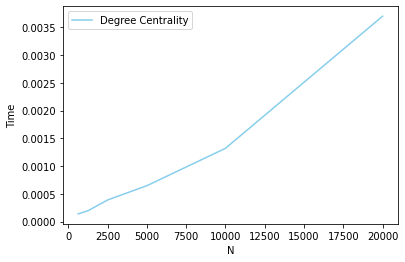

In [41]:
plt.plot(N,degree_centrality_time,color='skyblue',label = "Degree Centrality")
plt.xlabel('N')
plt.ylabel('Time')
plt.legend()
plt.show()


Pagerank and hub Complexity = O(n)

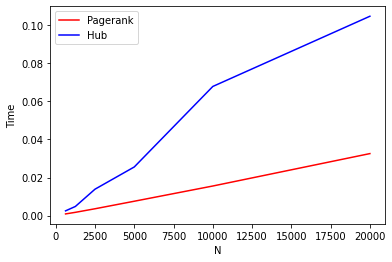

In [42]:
plt.plot(N,pagerank_time,color='red',label = "Pagerank")
plt.plot(N,hub_time,color='blue',label = "Hub")
plt.xlabel('N')
plt.ylabel('Time')
plt.legend()
plt.show()


Betweenness and closeness Complexity if of order O(n^2)

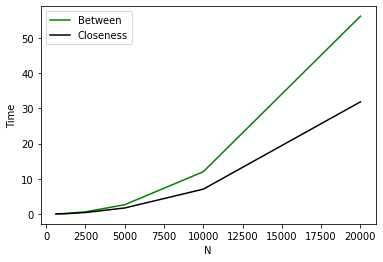

In [43]:
plt.plot(N,betweeness_time,color='green',label = "Between")
plt.plot(N,closeness_time,color='black',label = "Closeness");
plt.xlabel('N')
plt.ylabel('Time')
plt.legend()
plt.show()

Betweenness and closeness Complexity if of order O(n)

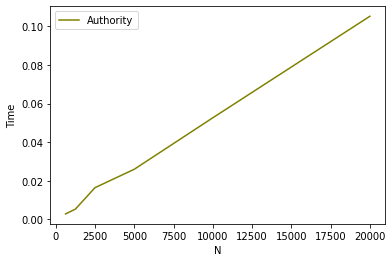

In [44]:
plt.plot(N,authority_time,color='olive',label = "Authority")
plt.xlabel('N')
plt.ylabel('Time')
plt.legend()
plt.show()



In [45]:
import timeit
degree_centrality_time = []
pagerank_time = []
authority_time = []
hub_time = []
betweeness_time = []
closeness_time = []
N = [625,1250,2500,5000,10000,20000]
for n in N:
    p = 8/(n-1)
    g = ig.Graph.Erdos_Renyi(n=n, p=p)
    z = g.shortest_paths()

    start = timeit.default_timer()
    degree_centrality(g)
    stop = timeit.default_timer()
    t = stop - start
    degree_centrality_time.append(t)

    start = timeit.default_timer()
    g.pagerank()
    stop = timeit.default_timer()
    t = stop - start
    pagerank_time.append(t)
    
    start = timeit.default_timer()
    g.authority_score()
    stop = timeit.default_timer()
    t = stop - start
    authority_time.append(t)

    start = timeit.default_timer()
    g.hub_score()
    stop = timeit.default_timer()
    t = stop - start
    hub_time.append(t)

    start = timeit.default_timer()
    g.betweenness()
    stop = timeit.default_timer()
    t = stop - start
    betweeness_time.append(t)

    start = timeit.default_timer()
    g.closeness()
    stop = timeit.default_timer()
    t = stop - start
    closeness_time.append(t)



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: closeness centrality is not well-defined for disconnected graphs at ../../../source/igraph/src/centrality.c:2874


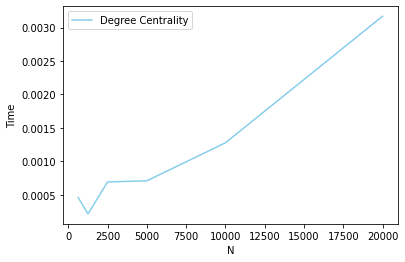

In [46]:
plt.plot(N,degree_centrality_time,color='skyblue',label = "Degree Centrality")
plt.xlabel('N')
plt.ylabel('Time')
plt.legend()
plt.show()


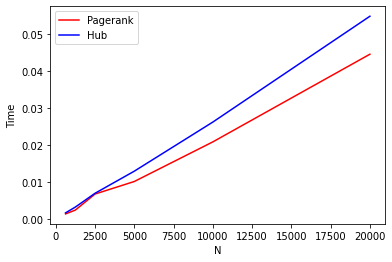

In [47]:
plt.plot(N,pagerank_time,color='red',label = "Pagerank")
plt.plot(N,hub_time,color='blue',label = "Hub")
plt.xlabel('N')
plt.ylabel('Time')
plt.legend()
plt.show()


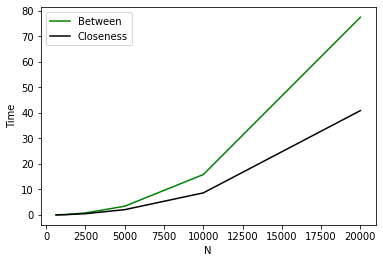

In [48]:
plt.plot(N,betweeness_time,color='green',label = "Between")
plt.plot(N,closeness_time,color='black',label = "Closeness");
plt.xlabel('N')
plt.ylabel('Time')
plt.legend()
plt.show()

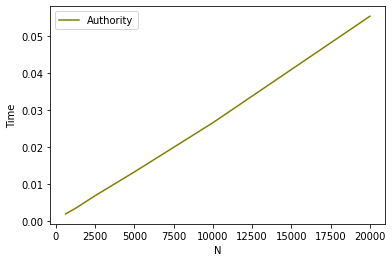

In [49]:
plt.plot(N,authority_time,color='olive',label = "Authority")
plt.xlabel('N')
plt.ylabel('Time')
plt.legend()
plt.show()

